In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Manejo de datasets

Es posible que para un problema de muchas variables, o con muchos datos, 
no sea posible cargar todo el dataset y el modelo en memoria, por lo que se deberá trabajar por lotes (batches). 
PyToch provee una herramienta muy útil para manejar datasets grandes.

Estas herramientas son las clases Dataset y Dataloader.

## La clase Dataset debe heredar de la clase madre torch.utils.data.Dataset, y debe tener definidos:

* el constructor: \_\_init\_\_()
* el metodo \_\_len\_\_(): que dice cuantos elementos tiene el dataset
* el metodo \_\_getitem\_\_(idx): proporciona a partir de un indice (idx) el elemento correspondiente

Veremos un ejemplo concreto para un dataset creado a partir de arrays de numpy

In [2]:
class Dataset(torch.utils.data.Dataset):
    # constructor
    def __init__(self, X, Y):
        '''Cuando solamente tenemos que leer dos arrays de numpy, el constructor es muy simple'''
        self.X = torch.from_numpy(X).float()
        self.Y = torch.from_numpy(Y).float()

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

## Clase Dataloader

Esta clase crea los iteradores necesarios para trabajar por batches, la implementacion es muy simple, basta pasarle el dataloader
```
torch.utils.data.DataLoader(dataset_object, batch_size= 64, shuffle=True)
```

Una vez que se tienen los dataloaders es conveniente realizar funciones o clases para entrenar y evaluar el modelo.

Veamos todo esto en un ejemplo simple

### **Analisis del dataset del SMN**

In [3]:
import csv, os, sys
import datetime
# necesitamos setear el path como variable de entorno para importar modulos
sys.path.append(os.path.join('..','..','libs'))
from read_smn import read_smn

In [4]:
lector = read_smn(os.path.join('..','..','Data','junio-SMN','horario'))
# veamos algun dato
lector.data_fmttd[297]

{'timestamp': datetime.datetime(2023, 6, 14, 18, 0),
 'temp': 14.3,
 'hum': 30.0,
 'pres': 1023.7,
 'v_direcc': 70.0,
 'v_intens': 7.0,
 'estac': 'CHAMICAL AERO'}

In [5]:
# Extraemos los datos de salta
tstamps, data = lector.filter_by_station('SALTA')
train_tstamps = tstamps[:600]
valid_tstamps = tstamps[600:]
train_temp = data[:600,0]
valid_temp = data[600:,0]

### Repitiendo la prediccion a partir de datos previos

Vamos a crear ventanas de datos para predecir el dato siguiente, por ejemplo dados 10 datos, predeciremos el 11vo

In [9]:
def create_training(X, lookback):
    x = []
    y = []
    for i in range(len(X)-lookback):
        x.append(X[i:i+lookback])
        y.append(X[i+lookback])
    return np.array(x), np.array(y)

# Hacemos todos los conjuntos de entrenamientos posibles mirando los 12 datos previos
lookback = 12
x_train, y_train = create_training(train_temp,lookback)
x_valid, y_valid = create_training(valid_temp,lookback)
print(f'train shape: {x_train.shape} - validation shape: {x_valid.shape}')

train shape: (588, 12) - validation shape: (108, 12)


## Creacion de los objetos Dataset de PyTorch 

In [10]:
# creamos los datasets y dataloaders en un diccionario para manejar mas simple
dataset = {'train': Dataset(x_train, y_train),
           'valid' : Dataset(x_valid, y_valid)}

dataloader = {'train' : torch.utils.data.DataLoader(dataset['train'], batch_size = 64, shuffle= True),
            'valid' : torch.utils.data.DataLoader(dataset['valid'], batch_size = 32, shuffle= True)}

In [11]:
# creamos un perceptron multicapa sencillito con una funcion de activacion Rectifier Linear Unit
class MLP(torch.nn.Module):
    # constructor
    def __init__(self, n_inputs, n_hidden, n_out) -> None:
        super(MLP, self).__init__()
        self.linear1 = torch.nn.Linear(n_inputs, n_hidden)
        self.activation = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(n_hidden, n_out)

    # paso forward
    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        return(x.view(-1))

In [12]:
# Instancia del modelo y dimensiones de sus parametros
mlp_net = MLP(lookback, 64, 1)
print(mlp_net)
print('numero de parametros:')
print('linear1: ', mlp_net.linear1.weight.shape, mlp_net.linear1.bias.shape)
print('linear2: ', mlp_net.linear2.weight.shape, mlp_net.linear2.bias.shape)

MLP(
  (linear1): Linear(in_features=12, out_features=64, bias=True)
  (activation): ReLU()
  (linear2): Linear(in_features=64, out_features=1, bias=True)
)
numero de parametros:
linear1:  torch.Size([64, 12]) torch.Size([64])
linear2:  torch.Size([1, 64]) torch.Size([1])


In [16]:
# veamos que entrega el modelo y el dataloader
print(mlp_net(torch.ones(32,lookback)).shape)
print(next(iter(dataloader['train']))[1].shape)

torch.Size([32])
torch.Size([64])


In [17]:
# como siempre se sigue una manera similar de entrenamiento, 
# conviene definir una funcion... 
# ... si se escribe muchas veces lo mismo es porque algo estamos haciendo mal

def fit(model, dataloader, epochs = 10):
    '''
    Funcion para entrenar el modelo model utilizando un dataloader
    '''
    optimizer = torch.optim.Adam(model.parameters(), lr= 0.001)
    criterion = torch.nn.MSELoss()
    history = []
    for epoch in range(1,epochs+1):
        model.train()   # ponemos el modelo para ser entrenado
        train_h = [] 
        
        # leer los datos en el dataloader es muy simple (recorrera por batches)! 
        for x_b, y_b in dataloader['train']:

            # ponemos los gradientes a cero
            optimizer.zero_grad()
            
            y_pred = model(x_b)
            loss = criterion(y_pred, y_b)

            # calculamos los gradientes
            loss.backward()
            
            # actualizamos todos los pesos
            optimizer.step()
            train_h.append(loss.item())

        model.eval() # no estamos entrenando
        test_h = [] 
        with torch.no_grad():  # no vamos a hacer backward, solo ver la metrica sobre el test
            for x_b, y_b in dataloader['valid']:
                y_pred = model(x_b)
                loss = criterion(y_pred, y_b)
                test_h.append(loss.item())
        if (epoch%10 == 0):
            print(f'epoch: {epoch}/{epochs} - train loss: {np.mean(train_h)} - valid loss: {np.mean(test_h)}')                
        history.append([np.mean(train_h), np.mean(test_h)])
    return history



In [26]:
hist = fit(mlp_net, dataloader, epochs=100)
print('----------------------------------------------')
print(f'train loss: {hist[-1][0]} - valid loss: {hist[-1][1]}')
print('----------------------------------------------')

epoch: 10/100 - train loss: 1.4956842899322509 - valid loss: 1.2588591277599335
epoch: 20/100 - train loss: 1.288161951303482 - valid loss: 1.161660686135292
epoch: 30/100 - train loss: 1.209617981314659 - valid loss: 1.0102628916502
epoch: 40/100 - train loss: 1.625906950235367 - valid loss: 1.5193394720554352
epoch: 50/100 - train loss: 1.2897391200065613 - valid loss: 0.9145370051264763
epoch: 60/100 - train loss: 1.2394636631011964 - valid loss: 1.1517163813114166
epoch: 70/100 - train loss: 1.190702247619629 - valid loss: 0.9753778576850891
epoch: 80/100 - train loss: 1.2567045152187348 - valid loss: 0.9299400895833969
epoch: 90/100 - train loss: 1.296812856197357 - valid loss: 1.0315546989440918
epoch: 100/100 - train loss: 1.21077418923378 - valid loss: 0.9264881983399391
----------------------------------------------
train loss: 1.21077418923378 - valid loss: 0.9264881983399391
----------------------------------------------


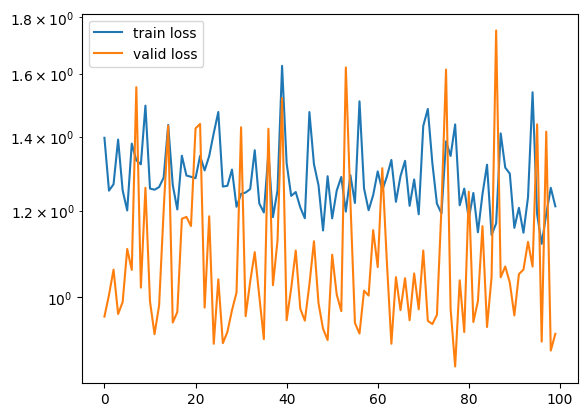

In [27]:
plt.semilogy([h[0] for h in hist], label= 'train loss')
plt.semilogy([h[1] for h in hist], label= 'valid loss')
plt.legend()
plt.show()

In [28]:
# Vamos a graficar algunos resultados del conjunto de validacion
# utilizando el dataloader
data_plot_x, data_plot_y = next(iter(dataloader["valid"]))
print(data_plot_x.shape, data_plot_y.shape)

torch.Size([32, 12]) torch.Size([32])


In [29]:
# es muy importante obtener vectores de numpy que no computen el gradiente
# para ello se usan los metodos detach() y numpy() como sigue
x_plot, y_true = data_plot_x.detach().numpy(), data_plot_y.detach().numpy()
y_pred = mlp_net(data_plot_x).detach().numpy()

# ademas vamos a comparar con los modelos naive y el de regresion lineal con delay (naive con delay)
# En la libreria Libs, el modulo prediction_models tiene definidos 
# dos modelos, el modelo naive, y el modelo delayed naive
import prediction_models as pm

# naive repite el ultimo valor de la serie
naive = pm.naive(x_plot)

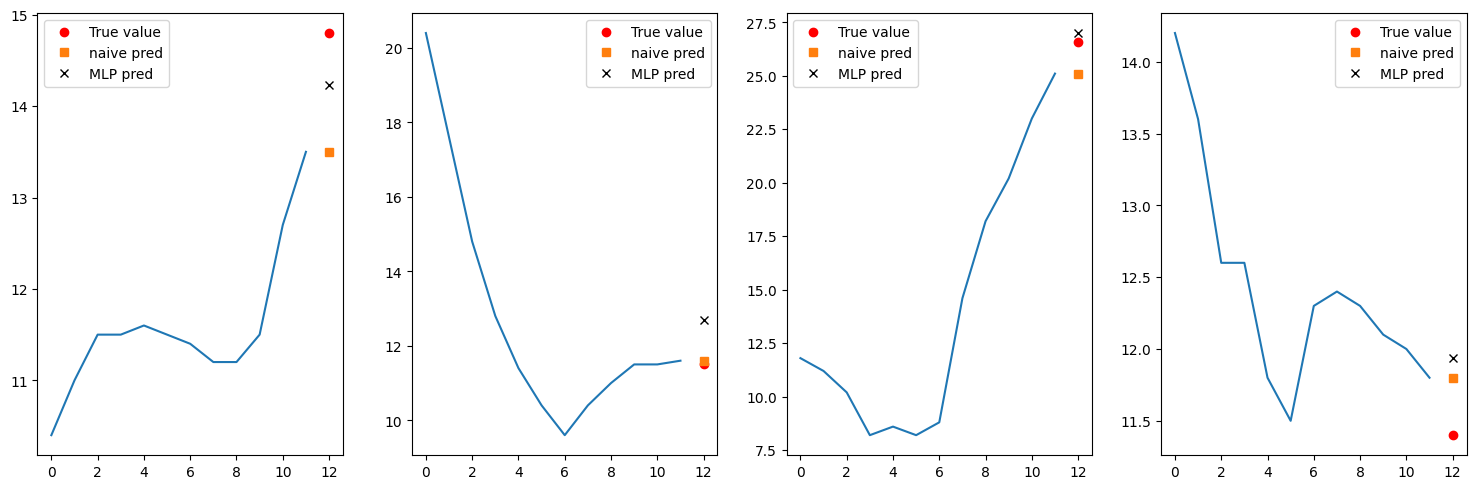

In [30]:
pidx = np.random.randint(0,32,4)
fig, axs = plt.subplots(1,4, figsize=(15,5))
for i in range(4):
    axs[i].plot(data_plot_x[pidx[i]])
    axs[i].plot(lookback, y_true[pidx[i]], 'ro', label = 'True value')
    axs[i].plot(lookback, naive[pidx[i]], 's', label = 'naive pred')
    axs[i].plot(lookback, y_pred[pidx[i]],'kx', label = 'MLP pred')
    axs[i].legend()
fig.tight_layout()
plt.show()

## Calculo de errores de prediccion mediante diversos modelos

In [31]:
# Delayed Naive model
dn_1 = pm.delayed_naive(train_temp, delay= 1)
dn_24 = pm.delayed_naive(train_temp,delay = 24)
print('-'*50)
print('Delayed Naive: delay 1')
print(dn_1.get_attributes())
print('-'*50)
print('Delayed Naive: delay 24')
print(dn_24.get_attributes())

--------------------------------------------------
Delayed Naive: delay 1
{'training_len': 599, 'training_MAE': 1.3240500158057933, 'slope': 0.9643994123217716, 'bias': 0.44454642308739345}
--------------------------------------------------
Delayed Naive: delay 24
{'training_len': 576, 'training_MAE': 2.8165604129690713, 'slope': 0.857721160354942, 'bias': 1.822767264018383}


In [32]:
from sklearn.metrics import mean_absolute_error

MLP_MAE = mean_absolute_error(y_true, y_pred)
naive_MAE = mean_absolute_error(y_true, naive)
dn1_MAE = mean_absolute_error(valid_temp[1:], dn_1.predict(valid_temp[:-1].reshape(-1,1)))
dn24_MAE = mean_absolute_error(valid_temp[24:], dn_24(valid_temp[:-24].reshape(-1,1)))
print('-'*50)
print('MAE for:')
print(f'\t MLP:\t\t {MLP_MAE}')
print(f'\t Naive:\t\t {naive_MAE}')
print(f'\t Delay 1:\t {dn1_MAE}')
print(f'\t Delay 24:\t {dn24_MAE}')

--------------------------------------------------
MAE for:
	 MLP:		 0.7912055253982544
	 Naive:		 1.2687501907348633
	 Delay 1:	 1.1369604022771957
	 Delay 24:	 3.2370556182737915
